## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Configuration

In [2]:
DATASET_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\dataset')
RESULTS_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\model_results\preprocessing')
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

BLOOD_GROUPS = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
IMAGE_SIZE = 224
BATCH_SIZE = 32

## Load Dataset & Split

In [3]:
# Collect images
data = []
for idx, bg in enumerate(BLOOD_GROUPS):
    for img_path in (DATASET_PATH / bg).glob('*.BMP'):
        data.append({'path': str(img_path), 'label': idx, 'class': bg})

df = pd.DataFrame(data)
print(f"Total images: {len(df)}")
print(df['class'].value_counts().sort_index())

# Split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"\nTrain: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Save splits
train_df.to_csv(RESULTS_PATH / 'train_split.csv', index=False)
val_df.to_csv(RESULTS_PATH / 'val_split.csv', index=False)
test_df.to_csv(RESULTS_PATH / 'test_split.csv', index=False)

Total images: 6000
class
A+      565
A-     1009
AB+     708
AB-     761
B+      652
B-      741
O+      852
O-      712
Name: count, dtype: int64

Train: 4200, Val: 900, Test: 900


## Class Weights

In [4]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("Class weights:")
for i, bg in enumerate(BLOOD_GROUPS):
    print(f"{bg}: {class_weights[i]:.3f}")

pd.DataFrame({'class': BLOOD_GROUPS, 'weight': class_weights}).to_csv(RESULTS_PATH / 'class_weights.csv', index=False)

Class weights:
A+: 1.326
A-: 0.744
AB+: 1.058
AB-: 0.985
B+: 1.151
B-: 1.012
O+: 0.881
O-: 1.054


## PyTorch Dataset

In [5]:
class BloodDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = Image.open(self.df.iloc[idx]['path']).convert('RGB')
        label = self.df.iloc[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

## Transforms & DataLoaders

In [6]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets
train_dataset = BloodDataset(train_df, train_transform)
val_dataset = BloodDataset(val_df, test_transform)
test_dataset = BloodDataset(test_df, test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 132
Val batches: 29
Test batches: 29


## Save Config

In [7]:
import json

config = {
    'image_size': IMAGE_SIZE,
    'batch_size': BATCH_SIZE,
    'num_classes': len(BLOOD_GROUPS),
    'classes': BLOOD_GROUPS,
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df)
}

with open(RESULTS_PATH / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("\n✓ Preprocessing complete!")
print(f"✓ Files saved to: {RESULTS_PATH}")


✓ Preprocessing complete!
✓ Files saved to: C:\Users\phoga\Desktop\HemoPrint\model_results\preprocessing


In [8]:
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Configuration

In [9]:
DATASET_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\dataset')
RESULTS_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\model_results\preprocessing')
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

BLOOD_GROUPS = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
IMAGE_SIZE = 224
BATCH_SIZE = 32

## Load Dataset & Split

In [10]:
# Collect images
data = []
for idx, bg in enumerate(BLOOD_GROUPS):
    for img_path in (DATASET_PATH / bg).glob('*.BMP'):
        data.append({'path': str(img_path), 'label': idx, 'class': bg})

df = pd.DataFrame(data)
print(f"Total images: {len(df)}")
print(df['class'].value_counts().sort_index())

# Split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"\nTrain: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Save splits
train_df.to_csv(RESULTS_PATH / 'train_split.csv', index=False)
val_df.to_csv(RESULTS_PATH / 'val_split.csv', index=False)
test_df.to_csv(RESULTS_PATH / 'test_split.csv', index=False)

Total images: 6000
class
A+      565
A-     1009
AB+     708
AB-     761
B+      652
B-      741
O+      852
O-      712
Name: count, dtype: int64

Train: 4200, Val: 900, Test: 900


## Class Weights

In [11]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("Class weights:")
for i, bg in enumerate(BLOOD_GROUPS):
    print(f"{bg}: {class_weights[i]:.3f}")

pd.DataFrame({'class': BLOOD_GROUPS, 'weight': class_weights}).to_csv(RESULTS_PATH / 'class_weights.csv', index=False)

Class weights:
A+: 1.326
A-: 0.744
AB+: 1.058
AB-: 0.985
B+: 1.151
B-: 1.012
O+: 0.881
O-: 1.054


## PyTorch Dataset

In [12]:
class BloodDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = Image.open(self.df.iloc[idx]['path']).convert('RGB')
        label = self.df.iloc[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

## Transforms & DataLoaders

In [13]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets
train_dataset = BloodDataset(train_df, train_transform)
val_dataset = BloodDataset(val_df, test_transform)
test_dataset = BloodDataset(test_df, test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 132
Val batches: 29
Test batches: 29


## Save Config

In [14]:
import json

config = {
    'image_size': IMAGE_SIZE,
    'batch_size': BATCH_SIZE,
    'num_classes': len(BLOOD_GROUPS),
    'classes': BLOOD_GROUPS,
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df)
}

with open(RESULTS_PATH / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("\n✓ Preprocessing complete!")
print(f"✓ Files saved to: {RESULTS_PATH}")


✓ Preprocessing complete!
✓ Files saved to: C:\Users\phoga\Desktop\HemoPrint\model_results\preprocessing


## 1. Import Libraries

In [15]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.4.1
CUDA available: True
Using device: cuda


## 2. Configuration

In [16]:
# Paths
DATASET_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\dataset')
RESULTS_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\model_results')

# Classes
BLOOD_GROUPS = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
NUM_CLASSES = len(BLOOD_GROUPS)

# Training parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"Dataset: {DATASET_PATH}")
print(f"Classes: {NUM_CLASSES}")
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

Dataset: C:\Users\phoga\Desktop\HemoPrint\dataset
Classes: 8
Image size: 224x224
Batch size: 32


## 3. Load Dataset

In [17]:
# Collect all image paths
data = []
for idx, blood_group in enumerate(BLOOD_GROUPS):
    group_path = DATASET_PATH / blood_group
    if group_path.exists():
        image_files = list(group_path.glob('*.BMP'))
        for img_path in image_files:
            data.append({
                'image_path': str(img_path),
                'blood_group': blood_group,
                'label': idx
            })

df = pd.DataFrame(data)
print(f"\nTotal images: {len(df)}")
print(f"\nClass distribution:")
print(df['blood_group'].value_counts().sort_index())


Total images: 6000

Class distribution:
blood_group
A+      565
A-     1009
AB+     708
AB-     761
B+      652
B-      741
O+      852
O-      712
Name: count, dtype: int64


## 4. Train/Val/Test Split

Training: 4199 (70.0%)
Validation: 900 (15.0%)
Test: 901 (15.0%)


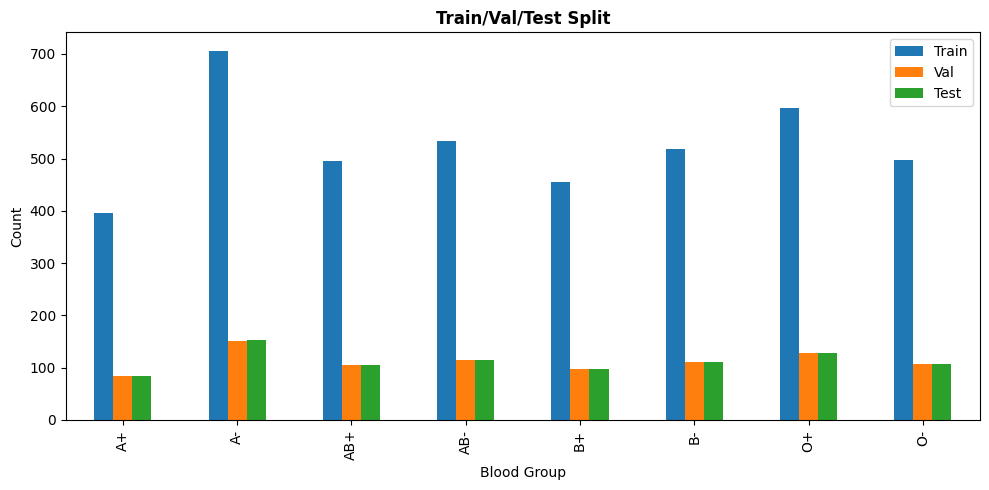

In [18]:
# Stratified split
train_df, temp_df = train_test_split(
    df, test_size=(1 - TRAIN_RATIO), stratify=df['blood_group'], random_state=42
)

val_ratio_adjusted = VAL_RATIO / (VAL_RATIO + TEST_RATIO)
val_df, test_df = train_test_split(
    temp_df, test_size=(1 - val_ratio_adjusted), stratify=temp_df['blood_group'], random_state=42
)

print(f"Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Visualize split
split_stats = pd.DataFrame({
    'Train': train_df['blood_group'].value_counts().sort_index(),
    'Val': val_df['blood_group'].value_counts().sort_index(),
    'Test': test_df['blood_group'].value_counts().sort_index()
})

fig, ax = plt.subplots(figsize=(10, 5))
split_stats.plot(kind='bar', ax=ax)
ax.set_title('Train/Val/Test Split', fontweight='bold')
ax.set_xlabel('Blood Group')
ax.set_ylabel('Count')
plt.tight_layout()
plt.savefig(RESULTS_PATH / 'data_split.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Calculate Class Weights

In [19]:
# Compute class weights for imbalanced data
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights = dict(enumerate(class_weights_array))
class_weights_tensor = torch.FloatTensor(class_weights_array).to(device)

print("Class Weights:")
for idx, bg in enumerate(BLOOD_GROUPS):
    print(f"  {bg}: {class_weights[idx]:.4f}")

# Save
pd.DataFrame({
    'blood_group': BLOOD_GROUPS,
    'weight': class_weights_array
}).to_csv(RESULTS_PATH / 'class_weights.csv', index=False)

print(f"\nSaved to: {RESULTS_PATH / 'class_weights.csv'}")

Class Weights:
  A+: 1.3288
  A-: 0.7434
  AB+: 1.0582
  AB-: 0.9848
  B+: 1.1510
  B-: 1.0113
  O+: 0.8807
  O-: 1.0540

Saved to: C:\Users\phoga\Desktop\HemoPrint\model_results\class_weights.csv


## 6. PyTorch Dataset

In [20]:
class BloodGroupDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

print("BloodGroupDataset class defined")

BloodGroupDataset class defined


## 7. Data Transforms & Augmentation

In [21]:
# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined:")
print("  Training: Resize, RandomRotation, RandomFlip, ColorJitter, Normalize")
print("  Val/Test: Resize, Normalize")

Transforms defined:
  Training: Resize, RandomRotation, RandomFlip, ColorJitter, Normalize
  Val/Test: Resize, Normalize


## 8. Create DataLoaders

In [22]:
# Create datasets
train_dataset = BloodGroupDataset(train_df, transform=train_transform)
val_dataset = BloodGroupDataset(val_df, transform=val_test_transform)
test_dataset = BloodGroupDataset(test_df, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

print(f"\nDataLoaders created:")
print(f"  Train: {len(train_dataset)} images, {len(train_loader)} batches")
print(f"  Val: {len(val_dataset)} images, {len(val_loader)} batches")
print(f"  Test: {len(test_dataset)} images, {len(test_loader)} batches")


DataLoaders created:
  Train: 4199 images, 132 batches
  Val: 900 images, 29 batches
  Test: 901 images, 29 batches


## 9. Visualize Augmentation

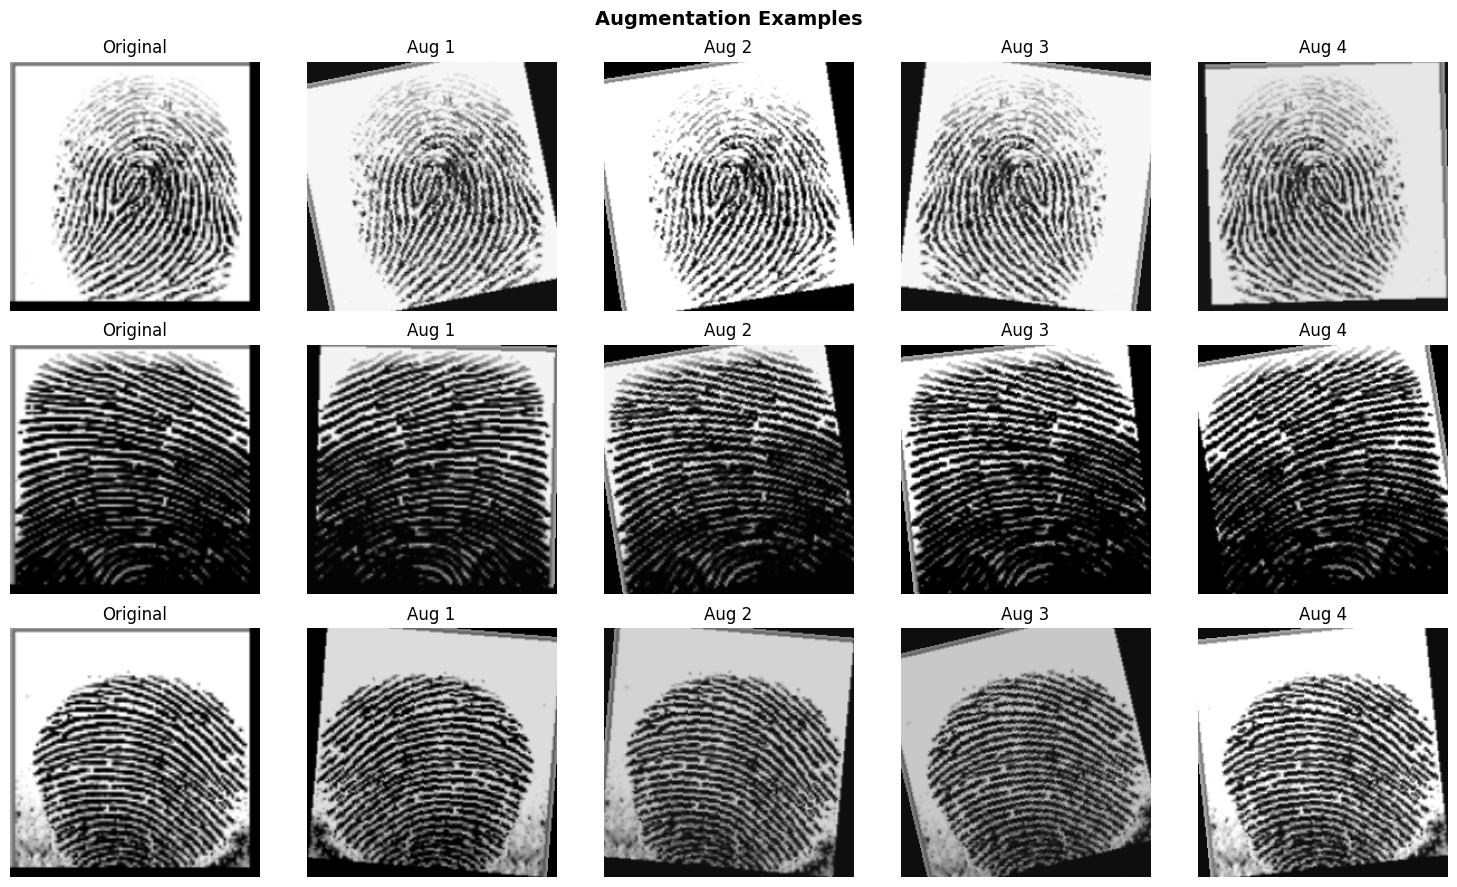

In [23]:
# Show augmentation examples
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Transform without normalization for visualization
vis_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

for i in range(3):
    # Get random image
    idx = np.random.randint(0, len(train_df))
    img_path = train_df.iloc[idx]['image_path']
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img)
    
    # Original
    original = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))(pil_img)
    axes[i, 0].imshow(original)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    # Augmented versions
    for j in range(1, 5):
        aug_img = vis_transform(pil_img)
        aug_img = aug_img.permute(1, 2, 0).numpy()
        axes[i, j].imshow(aug_img)
        axes[i, j].set_title(f'Aug {j}')
        axes[i, j].axis('off')

plt.suptitle('Augmentation Examples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_PATH / 'augmentation_samples.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Save Preprocessing Info

In [24]:
# Save split metadata
train_df.to_csv(RESULTS_PATH / 'train_split.csv', index=False)
val_df.to_csv(RESULTS_PATH / 'val_split.csv', index=False)
test_df.to_csv(RESULTS_PATH / 'test_split.csv', index=False)

# Save config
import json
config = {
    'image_size': IMAGE_SIZE,
    'batch_size': BATCH_SIZE,
    'num_classes': NUM_CLASSES,
    'class_names': BLOOD_GROUPS,
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df),
    'device': str(device)
}

with open(RESULTS_PATH / 'preprocessing_config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("\n" + "="*60)
print("PREPROCESSING COMPLETE")
print("="*60)
print(f"Total images: {len(df)}")
print(f"Train/Val/Test: {len(train_df)}/{len(val_df)}/{len(test_df)}")
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Device: {device}")
print(f"\nFiles saved to: {RESULTS_PATH}")
print("\nReady for model training!")
print("="*60)


PREPROCESSING COMPLETE
Total images: 6000
Train/Val/Test: 4199/900/901
Image size: 224x224
Batch size: 32
Device: cuda

Files saved to: C:\Users\phoga\Desktop\HemoPrint\model_results

Ready for model training!
